In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [2]:
# Change these 
training_data_dir = "./training_data/v2.2"
split_dir = "./training_data/splits/v2"

In [3]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [4]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')

In [5]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

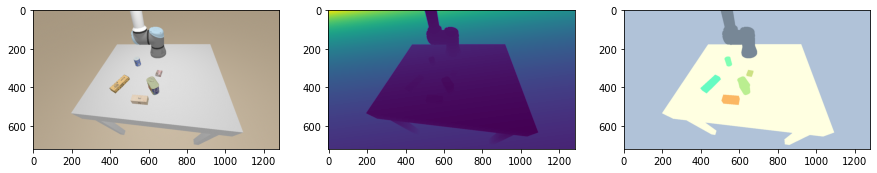

In [6]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [7]:
meta = load_pickle(meta_files[0])
meta.keys()

dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

In [8]:
meta['object_names'], meta['object_ids']

(['jenga', 'master_chef_can', 'potted_meat_can', 'pudding_box', 'wood_block'],
 array([35, 39, 48, 51, 58]))

In [9]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

## Lift depth to point cloud

In [10]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]

In [11]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

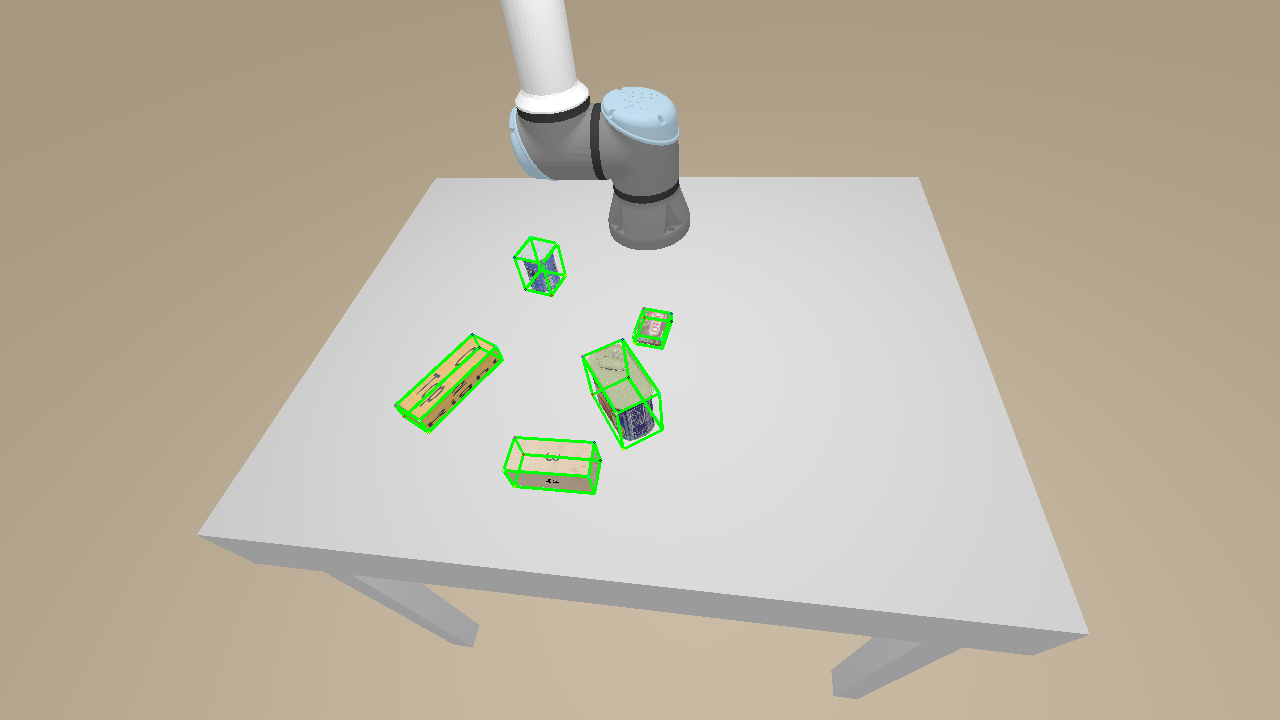

In [12]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [13]:
load_pickle("./testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

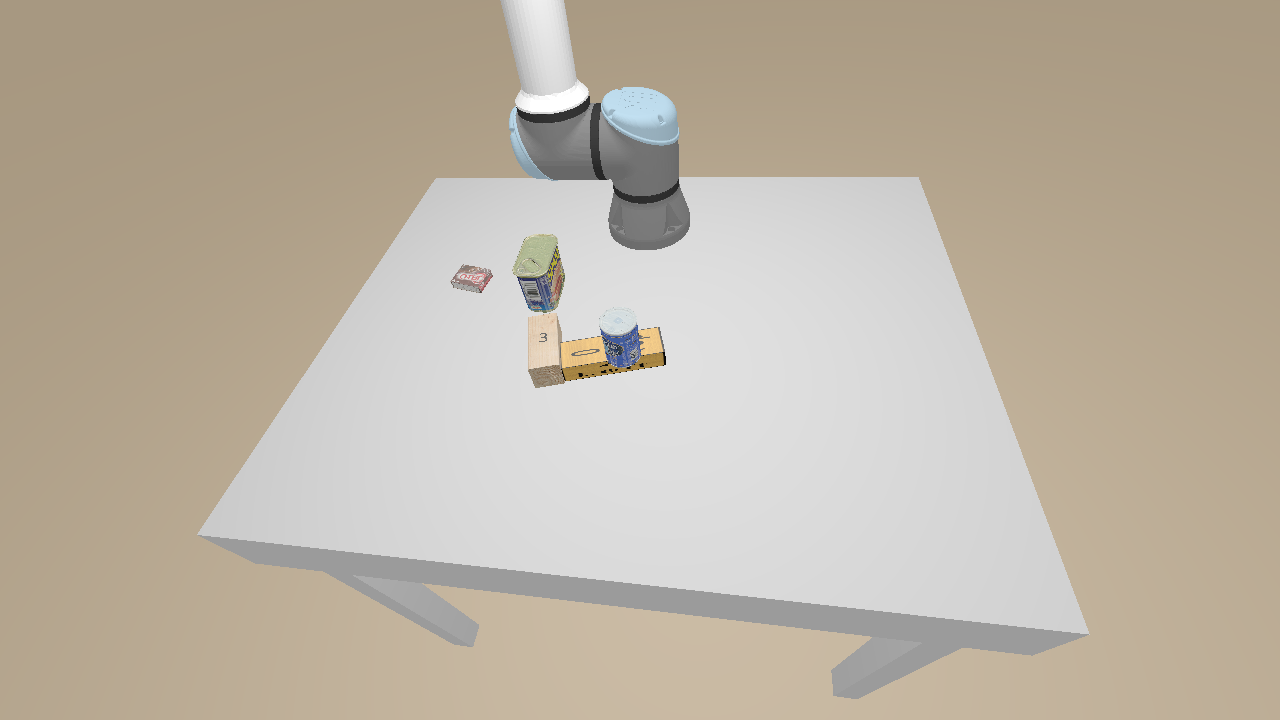

In [14]:
Image.open("./testing_data/v2.2/1-1-1_color_kinect.png")